# Fine-tuning a model for relation extraction task

# Dataset

In [ ]:
import pandas as pd
import io
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, AutoConfig, AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import List
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import random
import numpy as np


**ChemProt Corpus**

Chemical–protein relation corpus composed of 2432 PubMed abstracts, which were divided into a training set (1020 abstracts), development set (612 abstracts) and test set (800 abstracts)

Ссылка на оригинальную статью:
https://academic.oup.com/database/article/doi/10.1093/database/bay073/5055578

В этом ноутбуке будет использоваться BLUEBERT модель, обученная на PubMed abstracts. Эта модель показала хорошие результаты на рассматриваемом датасете.

Ссылки на бенчмарки: 
* https://github.com/ncbi-nlp/BLUE_Benchmark

* https://github.com/ncbi-nlp/bluebert

* Peng Y, Yan S, Lu Z. Transfer Learning in Biomedical Natural Language Processing: An Evaluation of BERT and ELMo on Ten Benchmarking Datasets. In Proceedings of the 2019 Workshop on Biomedical Natural Language Processing (BioNLP 2019). 2019:58-65.

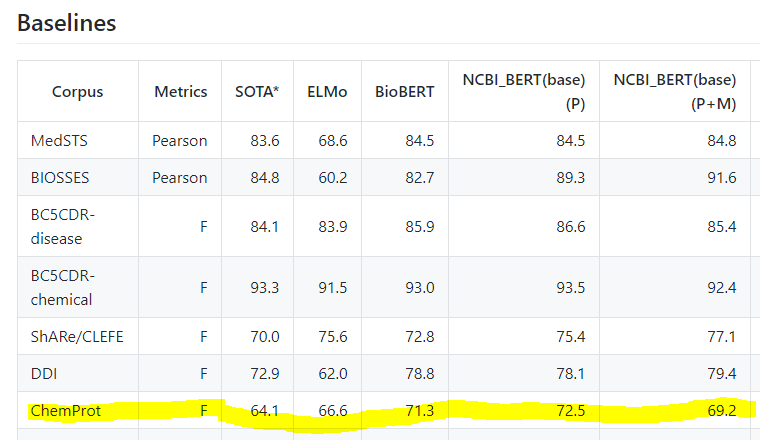

Ссылка на саму модель:

https://huggingface.co/bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12

In [ ]:
# loading data from local machine
from google.colab import files
uploaded = files.upload()

Saving dev.tsv to dev (2).tsv
Saving test.tsv to test (2).tsv
Saving train.tsv to train.tsv


In [ ]:
# printing names of the loaded files
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


User uploaded file "dev.tsv" with length 3300431 bytes
User uploaded file "test.tsv" with length 5084679 bytes
User uploaded file "train.tsv" with length 5464596 bytes


In [ ]:
uploaded['train.tsv'][:300]

b'index\tsentence\tlabel\r\n16357751.T1.T2\tRecent studies have provided consistent evidence that treatment with abatacept results in a rapid onset of efficacy that is maintained over the course of treatment in patients with inadequate response to @CHEMICAL$ and anti-@GENE$ therapies.\tfalse\r\n14967461.T1.T2'

In [ ]:

train_df = pd.read_csv((io.StringIO(uploaded['train.tsv'].decode('utf-8'))), sep='\t')
train_df.head()

,index,sentence,label
0,16357751.T1.T2,Recent studies have provided consistent eviden...,false
1,14967461.T1.T22,@CHEMICAL$ inhibitors currently under investig...,CPR:4
2,14967461.T2.T22,@CHEMICAL$ inhibitors currently under investig...,CPR:4
3,14967461.T3.T22,@CHEMICAL$ inhibitors currently under investig...,CPR:4
4,14967461.T4.T22,@CHEMICAL$ inhibitors currently under investig...,CPR:4


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19460 entries, 0 to 19459
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     19460 non-null  object
 1   sentence  19460 non-null  object
 2   label     19460 non-null  object
dtypes: object(3)
memory usage: 456.2+ KB


Example from dataset:

`index	sentence	label`

`14967461.T1.T22	@CHEMICAL$ inhibitors currently under investigation include the small molecules @GENE$ (Iressa, ZD1839) and erlotinib (Tarceva, OSI-774), as well as monoclonal antibodies such as cetuximab (IMC-225, Erbitux).	CPR:4`

**There are five types of chemical–protein relations**:
*   the biological properties upregulator (CPR: 3)
*   downregulator (CPR: 4)
*   agonist (CPR: 5)
*   antagonist (CPR: 6)
*   substrate (CPR: 9)

And one more class:

*   **false** class label means that the candidate tags in the sentence are not related.




In [ ]:
tag_to_idx = {
    'CPR:3': 0,
    'CPR:4': 1,
    'CPR:5': 2,
    'CPR:6': 3,
    'CPR:9': 4,
    'false': 5
}

In [ ]:
test_df = pd.read_csv((io.StringIO(uploaded['test.tsv'].decode('utf-8'))), sep='\t')
test_df.head()

,index,sentence,label
0,10076535.T44.T63,@CHEMICAL$ antagonistic effect of estramustine...,CPR:6
1,10076535.T45.T63,Androgen antagonistic effect of @CHEMICAL$ (EM...,CPR:6
2,10076535.T46.T63,Androgen antagonistic effect of estramustine p...,CPR:6
3,10076535.T47.T63,Androgen antagonistic effect of estramustine p...,false
4,10076535.T32.T59,"We investigated, by displacement of @CHEMICAL$...",false


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16943 entries, 0 to 16942
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     16943 non-null  object
 1   sentence  16943 non-null  object
 2   label     16943 non-null  object
dtypes: object(3)
memory usage: 397.2+ KB


In [ ]:
valid_df = pd.read_csv((io.StringIO(uploaded['dev.tsv'].decode('utf-8'))), sep='\t')
valid_df.head()

,index,sentence,label
0,10064839.T49.T56,Binding of dimemorfan to @CHEMICAL$ and its an...,false
1,10064839.T50.T56,Binding of @CHEMICAL$ to @GENE$ and its antico...,false
2,10064839.T51.T56,Binding of dimemorfan to @CHEMICAL$ and its an...,false
3,10064839.T40.T54,This study therefore characterized the binding...,false
4,10064839.T41.T54,This study therefore characterized the binding...,false


In [ ]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11820 entries, 0 to 11819
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     11820 non-null  object
 1   sentence  11820 non-null  object
 2   label     11820 non-null  object
dtypes: object(3)
memory usage: 277.2+ KB


In [ ]:
lens = []
for i in range(len(train_df)):
    lens.append(len(train_df.sentence.iloc[i].split()))

In [ ]:
max(lens)

116

# Train Setup

In [ ]:
MODEL_NAME = 'bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12'
NUM_EPOCHS = 3                         # smth around 2-6 epochs is typically fine when finetuning transformers
BATCH_SIZE = 4                        # depends on your available GPU memory (in combination with max seq length)
MAX_SEQ_LENGTH = 128                  # depends on your available GPU memory (in combination with batch size)
LEARN_RATE = 3e-5                      # learning rate is typically ~1e-5 for transformers
ACCUM_STEPS = 4                        # one optimization step for that many backward passes
SEED = 17                              # random seed for reproducibility
NUM_CLASSES = 6
MONITOR_METRIC = 'val_f1'


# Torch Dataset

In [ ]:
class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """
    def __init__(self,
                 texts: List[str],
                 labels: List[str] = None):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: 
        """

        self.texts = texts
        self.labels = np.array([tag_to_idx[lab] for lab in labels])
      

    def __len__(self):
        """
        Returns:
            int: length of the dataset
        """
        return len(self.texts)

    def __getitem__(self, index):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """

        # encoding the text
        x = self.texts[index]
        y = self.labels[index]
        
        return x, y


# Collator

In [ ]:
class TextClassificationCollator(object):
    """
    max_seq_length (int): maximal sequence length in tokens,
    texts will be stripped to this length
    model_name (str): transformer model name, needed to perform
    appropriate tokenization
    """
    def __init__(self, max_seq_length: int = 256, model_name: str = 'dmis-lab/biobert-base-cased-v1.1'):

        self.max_seq_length = max_seq_length

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def __call__(self, batch):

        text, labs = zip(*batch)
        
        # tokenized_text = self.tokenizer(text)
        output_dict = self.tokenizer.batch_encode_plus(
        list(text),
        add_special_tokens=True,
        pad_to_max_length=True,
        padding='longest',
        return_tensors="pt",
        return_attention_mask=True
        )
        labs = np.array(list(labs))
        labs = torch.as_tensor(labs)
        return output_dict['input_ids'], output_dict['attention_mask'], labs



In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
tokenizer.batch_encode_plus(["Hello, this one sentence!", "And this sentence goes with it."])

{'input_ids': [[101, 7592, 1010, 2023, 2028, 6251, 999, 102], [101, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

# BERT Classification Model

In [ ]:
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(self, pretrained_model_name: str,
                 num_classes: int = None, dropout: float = 0.3):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(
            pretrained_model_name, num_labels=num_classes)

        self.bert_model = AutoModel.from_pretrained(pretrained_model_name,
                                                    config=config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, attention_mask=None, head_mask=None):
        """Compute class probabilities for the input sequence.

        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class probabilities
        """
        assert attention_mask is not None, "attention mask is none"
        
        bert_output = self.bert_model(input_ids=features,
                                            attention_mask=attention_mask,
                                            head_mask=head_mask)
        # we only need the hidden state here and don't need
        # transformer output, so index 0
        seq_output = bert_output[0]  # (bs, seq_len, dim)
        # mean pooling, i.e. getting average representation for all tokens
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, dim)

        return logits

# Metric

In [ ]:
# taken from https://github.com/Erlemar/pytorch_tempest/blob/master/src/metrics/f1_score.py
from typing import Tuple


class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.
        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.
        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(
        predictions: torch.Tensor, labels: torch.Tensor, label_id: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label
        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label
        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions), torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision), torch.zeros_like(precision).type_as(true_positive), precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.
        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = torch.tensor(0.0)
        for label_id in labels.unique():
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

# Lightning Module

In [ ]:
class TextClassificationLightning(pl.LightningModule):

    def __init__(self):

        super().__init__()

        self.model = BertForSequenceClassification(pretrained_model_name=MODEL_NAME,
                                                   num_classes=NUM_CLASSES)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.metric = F1Score(average='micro')
        self.softmax = torch.nn.Softmax(dim=1)

        self.bs = BATCH_SIZE
        self.collate = TextClassificationCollator(model_name=MODEL_NAME,
                                                  max_seq_length=MAX_SEQ_LENGTH)

    def forward(self, x, *args, **kwargs):

        return self.model(x)

    def setup(self, stage):

        train_text = train_df.sentence.tolist()
        test_text = test_df.sentence.tolist()
        valid_text = valid_df.sentence.tolist()

        y_train = train_df.label.tolist()
        y_test = test_df.label.to_list()
        y_valid = valid_df.label.to_list()

        self.train_dataset = TextClassificationDataset(train_text, y_train)
        self.test_dataset = TextClassificationDataset(test_text, y_test)
        self.valid_dataset = TextClassificationDataset(valid_text, y_valid)

    def train_dataloader(self):

        train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.bs,
            collate_fn=self.collate,
            shuffle=False,
            num_workers=4
        )

        return train_loader

    def val_dataloader(self):

        valid_loader = torch.utils.data.DataLoader(
            self.valid_dataset,
            batch_size=self.bs,
            collate_fn=self.collate,
            shuffle=False,
            num_workers=4
        )

        return valid_loader

    def test_dataloader(self):

        test_loader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.bs,
            collate_fn=self.collate,
            shuffle=False,
            num_workers=4
        )

        return test_loader

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

        return (
             [optimizer],
             [{'scheduler': scheduler, 'interval': 'epoch', 'monitor': MONITOR_METRIC}]
         )

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, labs = batch

        logits = self.model(input_ids, attention_mask)
        loss = self.criterion(logits, labs)

        pred_classes = torch.argmax(self.softmax(logits), dim=1)
        labs = labs.flatten()
        f1_score = self.metric(pred_classes, labs)

        log = {'f1_score': f1_score, 'train_loss': loss.item()}
        # logging f1 score to progress bar
        self.log('f1_score', f1_score.item(), prog_bar=True)

        return {'loss': loss, 'log': log}

    def validation_step(self, batch, batch_idx):

        input_ids, attention_mask, labs = batch

        logits = self.model(input_ids, attention_mask=attention_mask)

        loss = self.criterion(logits, labs)

        pred_classes = torch.argmax((self.softmax(logits)), dim=1)

        labs = labs.flatten()

        f1_score = self.metric(pred_classes, labs)

        log = {'valid_loss': loss.item()}

        return {'valid_loss': loss, 'log': log, 'step_metric': f1_score,
                'predicted': pred_classes, 'true': labs}

    def validation_epoch_end(self, outputs):

        mean_loss = torch.stack([x['valid_loss'] for x in outputs]).mean()

        mean_metric = torch.stack([x['step_metric'] for x in outputs]).mean()

        self.log('val_f1', mean_metric, prog_bar=True)
        self.log('valid_mean_loss', mean_loss, prog_bar=True)

        return {'validation_loss': mean_loss, 'progress_bar': prog_log}

    def test_step(self, batch, batch_idx):

        input_ids, attention_mask, labs = batch

        logits = self.model(input_ids, attention_mask=attention_mask)
        loss = self.criterion(logits, labs)

        pred_classes = torch.argmax(self.softmax(logits), dim=1)
        labs = labs.flatten()

        f1_score = self.metric(pred_classes, labs)

        log = {'test_loss': loss.item()}

        return {'test_loss': loss, 'log': log, 'step_metric_test': f1_score,
                'predicted': pred_classes, 'true': labs}

    def test_epoch_end(self, outputs):

        mean_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        mean_metric = torch.stack([x['step_metric_test'] for x in outputs]).mean()
        self.log('test_f1', mean_metric, prog_bar=True)
        self.log('test_mean_loss', mean_loss, prog_bar=True)

        return {'test_loss': mean_loss}

   

In [ ]:
model = TextClassificationLightning()

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor=MONITOR_METRIC, save_top_k=1, filename='best_model')
early_stop_callback = pl.callbacks.EarlyStopping(monitor=MONITOR_METRIC, patience=2, mode='max', min_delta=0.001)

In [ ]:
torch.cuda.is_available()

True

In [ ]:

torch.cuda.current_device()

0

In [ ]:
def set_seed(seed: int = 777, precision: int = 10) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.set_printoptions(precision=precision)

In [ ]:
set_seed(777)

In [ ]:

trainer = Trainer(gpus=1, max_epochs=6, min_epochs=NUM_EPOCHS, deterministic=True, log_every_n_steps=100, num_sanity_val_steps=1,
                  accumulate_grad_batches=ACCUM_STEPS,
                  checkpoint_callback=checkpoint_callback, callbacks=[early_stop_callback])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [ ]:
trainer.fit(model)


  | Name      | Type                          | Params
------------------------------------------------------------
0 | model     | BertForSequenceClassification | 109 M 
1 | criterion | CrossEntropyLoss              | 0     
2 | softmax   | Softmax                       | 0     
------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.947   Total estimated model params size (MB)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [ ]:
trainer.test(model)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_f1': 0.8735835552215576,
 'test_loss': 0.3789244592189789,
 'test_mean_loss': 0.3789244592189789}
--------------------------------------------------------------------------------


[{'test_f1': 0.8735835552215576,
  'test_loss': 0.3789244592189789,
  'test_mean_loss': 0.3789244592189789}]

In [ ]:
# looking where was best model checkpoint saved
best_path = trainer.checkpoint_callback.best_model_path
print(best_path)

/content/lightning_logs/version_12/checkpoints/best_model.ckpt


In [ ]:
model = model.load_from_checkpoint(
    best_path, strict=False
)

In [ ]:
save_name = best_path.split('/')[-1][:-5]
# loading model from checkpoint
model = model.load_from_checkpoint(
    best_path, strict=False
)
model_name = f'{save_name}.pth'
print(model_name)
torch.save(model.model.state_dict(), model_name)

best_model.pth


In [ ]:
from google.colab import files
files.download(best_path)

FileNotFoundError: ignored